# Ноутбук с нейронкой для предсказаний

## Подготовка данных

Импортируем

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
# from apex import amp

import gc
from PIL import Image

Подключаем Google диск



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем данные: бинарные маски и симуляции дифракции по ним

In [3]:
simulations = np.load('/content/drive/MyDrive/simulations.npy', allow_pickle=True)
dataset = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)

Для работы с полным датасетом не хватает вычислительной мощности. Поэтому отрезаем от него часть.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_start = 0
N_end = simulations.shape[0]
data_step = 2
X = torch.from_numpy(simulations[N_start:N_end:data_step].reshape(-1, 1, 513, 513)).half().to(device)
y = torch.from_numpy(dataset[N_start:N_end:data_step].reshape(-1, 1, 513, 513)).half().to(device)

Освобождаем память

In [5]:
del simulations
del dataset

Делим данные на обучение, валидацию и тест

In [6]:
bs = 10

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=bs)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

scaler = torch.cuda.amp.GradScaler()

In [7]:
# del X_train, X_val_test, y_train, y_val_test
# del X_val, y_val
# del train_data, val_data

## Обучение модели

Функция, которая обучает модель

In [8]:
def train(model, criterion, optimizer, X, y, n_epochs, n_stop=10):
    min_val_loss = np.inf
    f = 0
    for epoch in range(n_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
          
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X)
                loss = criterion(_y_pred, _y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        mean_val_loss = 0
        batch_count = 0
        for batch in val_loader:
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                _y_pred = model(_X)
                loss = criterion(_y_pred, _y)
            mean_val_loss += loss.item()
            batch_count += 1

        mean_val_loss /= batch_count

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, \tValidation loss: {(mean_val_loss)}')

        if round(mean_val_loss, 3) >= min_val_loss:
            f = f + 1
        else:
            f = 0
            best_model = deepcopy(model)
            min_val_loss = round(mean_val_loss, 3)
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model #, train_loss, val_loss

Функция для подсчета ошибки на тесте

In [9]:
def test_loss(model, criterion):
  mean_loss = 0
  batch_count = 0
  for batch in test_loader:
    with torch.no_grad():
      _X, _y = batch
      _X, _y = _X.cpu().float(), _y.cpu().float()
      # with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
      model.cpu()
      y_pred = model(_X)
      loss = criterion(y_pred, _y)
      mean_loss += loss.item()
      batch_count += 1
    
  return mean_loss / batch_count

Два варианта модели CNN

In [13]:
# Define the CNN architecture
ch_b = 2
class CNN1(torch.nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    ks = 9
    self.conv1 = torch.nn.Conv2d(1, ch_b, kernel_size=ks, padding=ks-1, dilation=2) # 513
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)                # 256
    self.conv2 = torch.nn.Conv2d(ch_b, ch_b * 2, kernel_size=ks, padding=ks-1, dilation=2) # 256
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)                # 128
    self.fc1 = torch.nn.Linear(ch_b * 2 * 128 * 128, 128)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, ch_b * 2 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    return x.view(-1, 1, 513, 513)

In [11]:
# Define the CNN architecture
ch_b = 2
class CNN2(torch.nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, ch_b, kernel_size=6, padding=5, dilation=2) # 513
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)                # 256
    self.conv2 = torch.nn.Conv2d(ch_b, ch_b * 2, kernel_size=6, padding=5, dilation=2) # 256
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)                # 128
    self.fc1 = torch.nn.Linear(ch_b * 2 * 128 * 128, 128)
    # self.dropout2 = torch.nn.Dropout(0.2)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, ch_b * 2 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    x = torch.relu(x)
    return x.view(-1, 1, 513, 513)

В этой ячейке можно проверить работу слоя

In [26]:
# m = nn.MaxPool2d(kernel_size=4)
m = torch.nn.Conv2d(1, 1, kernel_size=8, padding=7, dilation=2)
s = 513
input = torch.randn(1, s, s)
output = m(input)
output.size()

torch.Size([1, 513, 513])

Можно загрузить уже обученную модель

In [9]:
model = torch.load('/content/drive/MyDrive/models/model4123', map_location=torch.device('cpu')).to(device)
# model.cuda()

Обучаем модель

In [16]:
# Instantiate the CNN
model = CNN1().to(device)
model.cuda()

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# with torch.autograd.detect_anomaly(check_nan=True):
model = train(model, criterion, optimizer, X, y, n_epochs=1000, n_stop=50)

Epoch: 0, 	Validation loss: nan


KeyboardInterrupt: ignored

Считаем ошибку на тесте

In [13]:
criterion = torch.nn.MSELoss()
print(f'Test loss: {test_loss(model, criterion)}')

Test loss: 4898.533233642578


Сохраняем модель, если понравилась

In [12]:
torch.save(model, '/content/drive/MyDrive/models/model4560')

## Проверка модели на практике

Следующие ячейки нужны для предсказания маски для какой-то конкретной картинки. Это предсказание можно сохранить, сделать по нему симуляцию и сравнить ее с исходной картинкой. 

In [13]:
circle_np = np.array(Image.open('/content/drive/MyDrive/prediction_test/cooler_circle.png').convert("L")) / 64
# circle_np = np.load('/content/drive/MyDrive/dif/sim18.npy')
circle =  torch.from_numpy(circle_np.reshape(1, 513, 513)).half().to(device)
model.cuda()
with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
  circle_pred = model(circle)

In [14]:
def frame_plot(arr, ax):
  rectX = np.linspace(0, 1, arr.shape[0])
  rectY = np.linspace(0, 1, arr.shape[1])
  x, y = np.meshgrid(rectX, rectY)
  ax.pcolormesh(x, y, arr)

In [15]:
circle_pred_np = circle_pred.cpu().detach().numpy().reshape(513, 513)

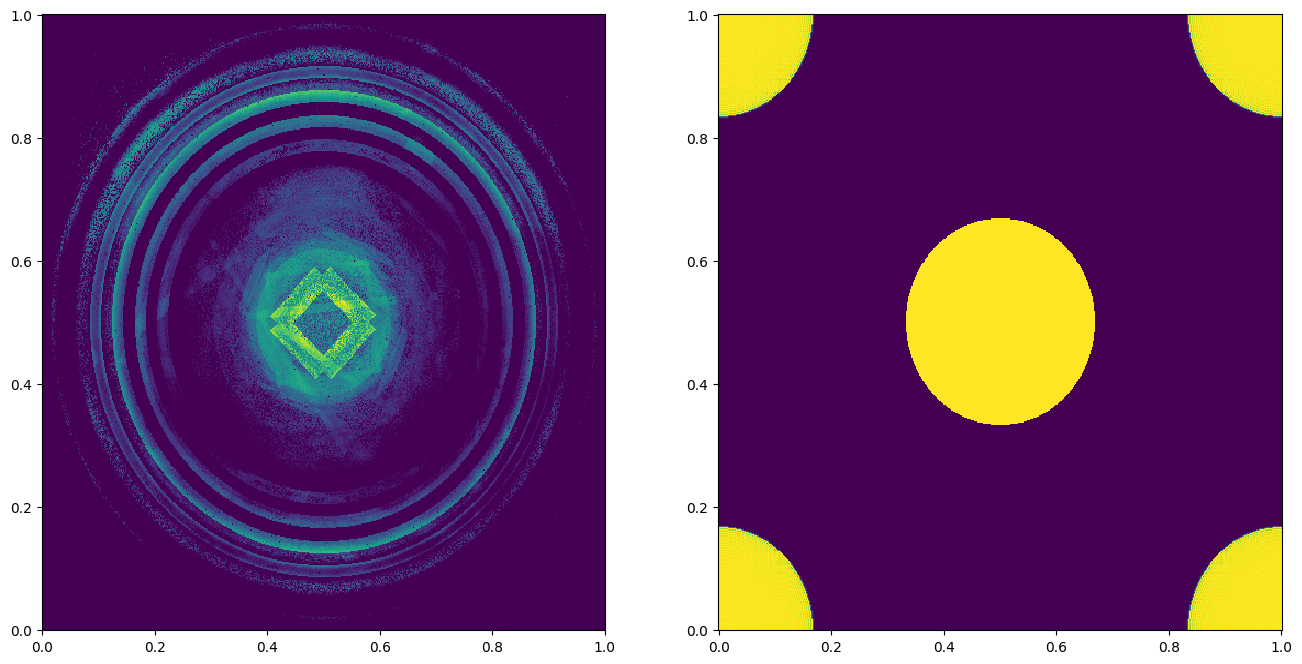

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(circle_pred_np, ax=ax[0])
frame_plot(circle_np, ax=ax[1])

In [40]:
circle_pred_np[256][256]

74.3

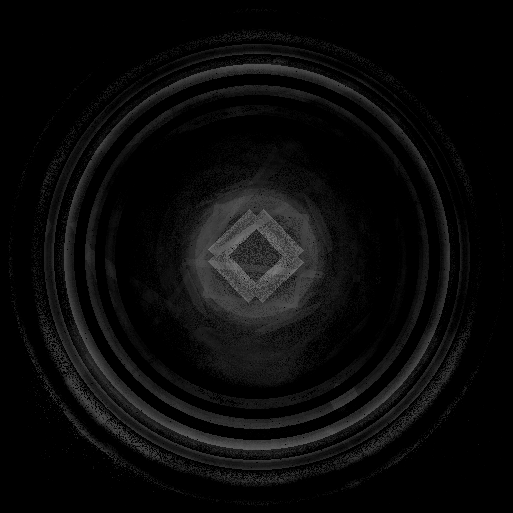

In [17]:
circle_im = Image.fromarray(circle_pred_np.astype(np.uint8))
circle_im = circle_im.convert('L')
circle_im.show()
# circle_im.save('/content/drive/MyDrive/prediction_test/circle_pred2.png')